# Trying to do plots for the momentum paper. 

## I want to plot:
- Compare to Seager parameterization
- Check the performance when I coarse-grain a second time.
- Show a local time dependent plots where below I want to plot the total precipitation.  to show improve performance in convecting regions
- To show that the momentum flux is much more noisy than say q_advection
- Show that at snapshots the momentum flux is pretty uniform in the vertical (and how it propagates in the stratosphere)
- show R^2 performance

As test I am using the last 501 files (used to use 225 files). 

To verify the no qp data and that the momentum data are taken from the same snapshots.


In [1]:
import os
import numpy as np
import time
from src.ml_io import write_netcdf_nn
import src.ml_io as ml_io
import src.ml_load as ml_load
# import src.ml_train as ml_train
import src.ml_train_nn as ml_train
import math
import pandas as pd
from sklearn.metrics import r2_score
import pickle
# import matplotlib as plt
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
from torch import nn, optim
from time import time

from sklearn.metrics import r2_score

from torch_lr_finder import LRFinder
from netCDF4 import Dataset
import netCDF4
from scipy.stats import pearsonr
from scipy import stats

import nbimporter

from Process_plot_functions import *

%matplotlib inline  
# from fastai.tabular import *


  pip install torch-lr-finder -v --global-option="amp"


In [2]:
os.chdir('/glade/u/home/janniy/convection_parametrization/paul_codes/ML-convection_sam_flex_io/src')


# Prepare data:

In [37]:
X8 = True
no_c_grid_flag = True # IF I want to use all variables on the same grid
predict_abs_val_no_c_grid = False # When I predict the absolute value

if X8:
#     path_to_data = '/glade/work/janniy/data_for_offline_momentum_paper/producation_offline_data/'
    path_to_data = '/glade/work/janniy/data_for_offline_momentum_paper/'
    file_no_qp = 'qobsTTFFFFFTF30FFTFTF30TTFTFTFFF80FFFFTTF2699FFTF_X01_cor_val_training_3D.pkl'
    if predict_abs_val_no_c_grid and no_c_grid_flag:
        network_path = 'qobsFFTFFFFFF0FFTFTF48FFFFFFFTT815FFTTTTF3048FF_X01_no_c_grid_fluxabs_mom_F-Stan_O-Stan_Ntr13856040_Nte729360_F_T_instead_qin_u_v_disteq_O_tkz_u_flux_ABS_v_flux_ABS_usf_vsf_7ep_NN_layers5in157out111_BN_F_te45_tr47stage2.pth'
        network_path_nc ='qobsFFTFFFFFF0FFTFTF48FFFFFFFTT815FFTTTTF3048FF_X01_no_c_grid_fluxabs_mom_F-Stan_O-Stan_Ntr13856040_Nte729360_F_T_instead_qin_u_v_disteq_O_tkz_u_flux_ABS_v_flux_ABS_usf_vsf_7ep_NN_layers5in157out111_BN_F_te45_tr47.nc'
        file_momentum = 'qobsFFTFFFFFF0FFTFTF48FFFFFFFFFFTF815FFTTTTF30483D_np_no_c_gridabs_mom99_training_x_no_subsampling_uv.npz'
    elif no_c_grid_flag:
        network_path = 'qobsFFTFFFFFF0FFTFTF48FFFFFFFTT815FFTTTTF3048FF_X01_no_c_grid_flux_F-Stan_O-Stan_Ntr13856040_Nte729360_F_T_instead_qin_uug_vug_disteq_O_tkz_u_flux_v_flux_usf_vsf_7ep_NN_layers5in157out111_BN_F_te26_tr28stage2.pth'
        network_path_nc ='qobsFFTFFFFFF0FFTFTF48FFFFFFFTT815FFTTTTF3048FF_X01_no_c_grid_flux_F-Stan_O-Stan_Ntr13856040_Nte729360_F_T_instead_qin_uug_vug_disteq_O_tkz_u_flux_v_flux_usf_vsf_7ep_NN_layers5in157out111_BN_F_te26_tr28.nc'
        file_momentum = 'qobsFFTFFFFFF0FFTFTF48FFFFFFFFFFTF815FFTTTTF30483D_np_no_c_grid99_training_x_no_subsampling_uv.npz'
    elif predict_abs_val_no_c_grid:
        network_path = 'qobsFFTFFFFFF0FFTFTF48FFFFFFFTT815FFTTTTF3048FF_X01_u_v_fluxabs_mom_F-Stan_O-Stan_Ntr13856040_Nte729360_F_T_instead_qin_u_v_disteq_O_tkz_u_flux_ABS_v_flux_ABS_usf_vsf_7ep_NN_layers5in157out111_BN_F_te50_tr51stage2.pth'
        network_path_nc = 'qobsFFTFFFFFF0FFTFTF48FFFFFFFTT815FFTTTTF3048FF_X01_u_v_fluxabs_mom_F-Stan_O-Stan_Ntr13856040_Nte729360_F_T_instead_qin_u_v_disteq_O_tkz_u_flux_ABS_v_flux_ABS_usf_vsf_7ep_NN_layers5in157out111_BN_F_te50_tr51.nc'
        file_momentum = 'qobsFFTFFFFFF0FFTFTF48FFFFFFFFFFTF815FFTTTTF30483D_npabs_mom99_training_x_no_subsampling_uv.npz'
    else:
        network_path = 'qobsFFTFFFFFF0FFTFTF48FFFFFFFTT815FFTTTTF3048FF_X01_u_v_flux_F-Stan_O-Stan_Ntr13856040_Nte729360_F_T_instead_qin_uug_vug_disteq_O_tkz_u_flux_v_flux_usf_vsf_NN_layers5in157out111_BN_F_te14_tr15stage2.pth'
        network_path_nc = 'qobsFFTFFFFFF0FFTFTF48FFFFFFFTT815FFTTTTF3048FF_X01_u_v_flux_Ntr13856040_Nte729360_F_T_instead_qin_uug_vug_disteq_O_tkz_u_flux_v_flux_usf_vsf_NN_layers5in157out111_te14_tr15.nc'
        file_momentum = 'qobsFFTFFFFFF0FFTFTF48FFFFFFFFFFTF815FFTTTTF30483D_np99_training_x_no_subsampling_uv.npz'
    
    file_no_qp_48_levels = 'qobsTTFFFFFTF48FFTFTF48TTFTFTFFF80FFFFTTF4899FFTF_X01_cor_val_training_3D_501_snapshots.pkl'  
    network_moisture_energy_try = 'qobsTTFFFFFTF30FFTFTF30TTFTFTFFF80FFTFTTF2699FFFF_X01_cor_val_F-Stan_O-Stan_Ntr13856040_Nte729360_F_Tin_qin_disteq_O_Trad_rest_Tadv_qadv_qout_qsed_RESCALED_7epochs_no_drop_NN_layers5in61out148_BN_F_te70_tr70stage2.pth'
    file_u_v_grid_no_c = 'qobsFFTFFFFFF0FFTFTF48FFFFFFFFFFTF810FFTTTTF30483D_np_u_v_grid_flux99_training_x_no_subsampling_uv.npz'
    file_no_c_grid ='qobsFFTFFFFFF0FFTFTF48FFFFFFFFFFTF810FFTTTTF30483D_np_no_c_grid99_training_x_no_subsampling_uv.npz'    

    # 48 levels temperature:
data_l_48_lev = pickle.load(open(path_to_data +  file_no_qp_48_levels, 'rb'))
v_48_lev = dict()
v_48_lev['Tin'] = np.float32(data_l_48_lev[0])
v_48_lev['qTin'] = np.float32(data_l_48_lev[1])
v_48_lev['Tadv'] = np.float32(data_l_48_lev[4])
v_48_lev['qadv'] = np.float32(data_l_48_lev[5])
v_48_lev['qout'] = np.float32(data_l_48_lev[6])

In [38]:
        
v_mom= dict()
loaded = np.load(path_to_data + file_momentum)
input_vert_vars_mom = ['Tin','qin','uin','vin','dist']
output_vert_vars_mom = ['tkz','u_flux','v_flux','u_surf','v_surf']

varis_mom = input_vert_vars_mom + output_vert_vars_mom
for ind, var in enumerate(varis_mom, start=0):
    v_mom[var] = np.float32(loaded[var])  # I put it as float 32 since some of the python functions that I use have a problem with float16.
    y = loaded['y']
    z = loaded['z']
    p = loaded['p']
    rho = loaded['rho']
dim1 = 48
dim2 = dim1-1
input_vert_dim = [30,30,dim1,dim1,1] #Dependent on the scenario we chose to model. This should give some flexibility to our coding.
output_vert_dim = [15,dim2,dim2,1,1]

In [5]:
#load means and stds
f = Dataset(path_to_data + network_path_nc, mode='r')
out_mean = f.variables['oscale_mean'][:]
out_std = f.variables['oscale_stnd'][:]
in_mean = f.variables['fscale_mean'][:]
in_std = f.variables['fscale_stnd'][:]

In [6]:
indices_outputs = np.zeros(len(output_vert_dim)+1)
for ind, val in zip(range(len(output_vert_dim)),output_vert_dim):
    indices_outputs[ind + 1] = indices_outputs[ind] + val


In [7]:
indices_inputs = np.zeros(len(output_vert_dim)+1)
for ind, val in zip(range(len(input_vert_dim)),input_vert_dim):
    indices_inputs[ind + 1] = indices_inputs[ind] + val


In [8]:
build_data = 0 # If I want to use an npz file to build that data file. 0 if I already built the fule. 


if predict_abs_val_no_c_grid and no_c_grid_flag:
    save_load_name = 'x8_1D_test_paper_no_c_grid_absolute_val_flux'
elif no_c_grid_flag:
    save_load_name = 'x8_1D_test_paper_no_c_grid'
elif predict_abs_val_no_c_grid:
    save_load_name = 'x8_1D_test_paper_with_c_grid_absolute_val_flux'
else:
    save_load_name = 'x8_1D_test_paper'
    
print(save_load_name)
if build_data == 1:
    input_vec, output_vec = normalized_data_1D(loaded,input_vert_vars_mom,indices_inputs, output_vert_vars_mom,in_mean,in_std,out_mean,out_std)
    Xin_scl = prepare_input_samples(input_vec,hor_size_x=1, hor_size_y = 1)
    output_vec = reshape_output_from_3D(output_vec)      
    print('saving:')
    save_training_file(path_to_data + save_load_name,Xin_scl,output_vec)
else:
    X_py_val, y_train_py_val,val_loader, torch_dataset_val = build_validation_1D(path_val= path_to_data + save_load_name + '.npz')
        
    

x8_1D_test_paper_no_c_grid


In [9]:
fully_u_v_tkz = Net_fully_1x1()
path_load = path_to_data + network_path
fully_u_v_tkz.load_state_dict(torch.load(path_load))

<All keys matched successfully>

In [10]:
print('I predict small fractions due to memory issues')
predictions = torch.zeros((X_py_val.shape[0],111))
i_num = np.arange(0,X_py_val.shape[0],100000)
i_num =  np.append(i_num,X_py_val.shape[0])

for ii in range(i_num.shape[0]-1):
    predictions[i_num[ii]:i_num[ii+1],:] = fully_u_v_tkz(X_py_val[i_num[ii]:i_num[ii+1],:,0,0])

I predict small fractions due to memory issues


In [11]:
#Calculate R^2 for the real variables. Collocated grid
#X4
indices = np.zeros(len(output_vert_dim)+1)
for ind, val in zip(range(len(output_vert_dim)),output_vert_dim):
    indices[ind + 1] = indices[ind] + val
for jj in range(len(output_vert_dim)):
    indices[jj]
    print(r2_score(np.reshape(y_train_py_val.detach().numpy()[:,int(indices[jj]):int(indices[jj+1])],-1),np.reshape(predictions.detach().numpy()[:,int(indices[jj]):int(indices[jj+1])],-1)))    
    

0.7803387335552933
0.18307865751662644
0.2114396711362393
0.5741637150000387
0.4990786524227583


In [11]:
#Calculate R^2 for the real variables. for absolute value
#X4
indices = np.zeros(len(output_vert_dim)+1)
for ind, val in zip(range(len(output_vert_dim)),output_vert_dim):
    indices[ind + 1] = indices[ind] + val
for jj in range(len(output_vert_dim)):
    indices[jj]
    print(r2_score(np.reshape(y_train_py_val.detach().numpy()[:,int(indices[jj]):int(indices[jj+1])],-1),np.reshape(predictions.detach().numpy()[:,int(indices[jj]):int(indices[jj+1])],-1)))    
    

0.8144886393651563
0.5154774131592973
0.5077086659162668
0.5958813295549634
0.5076912826006932


In [11]:
#Calculate R^2 for the real variables. C-grid
#X4
indices = np.zeros(len(output_vert_dim)+1)
for ind, val in zip(range(len(output_vert_dim)),output_vert_dim):
    indices[ind + 1] = indices[ind] + val
for jj in range(len(output_vert_dim)):
    indices[jj]
    print(r2_score(np.reshape(y_train_py_val.detach().numpy()[:,int(indices[jj]):int(indices[jj+1])],-1),np.reshape(predictions.detach().numpy()[:,int(indices[jj]):int(indices[jj+1])],-1)))    
    

0.8047406538131193
0.033034680457106
0.0873963706767189
0.5883554663968806
0.5134091518488711


In [12]:
out_mean_dict = dict()
out_std_dict = dict()

ind1 = 0
for var in output_vert_vars_mom:
    out_mean_dict[var] = out_mean[ind1]
    out_std_dict[var] = out_std[ind1]
    ind1 = ind1 + 1
    

In [13]:
inv_output_pred_test = inv_normalized_outputs(predictions.detach().numpy(),output_vert_vars_mom,output_vert_dim,out_mean_dict,out_std_dict)
inv_output_true_test = inv_normalized_outputs(y_train_py_val.detach().numpy(),output_vert_vars_mom,output_vert_dim,out_mean_dict,out_std_dict)


In [14]:
if X8:
    shape_3D_x8 = [501,180,72]

        
inv_output_pred_test_3D = inv_reshape_output_to_3D(inv_output_pred_test,shape_3D_x8)
inv_output_true_test_3D = inv_reshape_output_to_3D(inv_output_true_test,shape_3D_x8)



In [15]:
pred_coarse = coarse_var(inv_output_pred_test_3D,coarse_fact=2)
true_coarse = coarse_var(inv_output_true_test_3D,coarse_fact=2)


In [16]:
r2_coarse = r2_2D(true_coarse,pred_coarse)
r2_full = r2_2D(inv_output_true_test_3D,inv_output_pred_test_3D)

In [17]:
# SAVE R^2 values for plot later:
# path_save_data_for_plots = '/glade/work/janniy/data_for_offline_momentum_paper/data_for_plots/'
# pickle.dump(r2_full, open(path_save_data_for_plots  + 'r2_full_for_momentum_x8_with_c_grid_501_snapshots.pkl', 'wb'))

In [18]:
# SAVE R^2 values for plot later:
# path_save_data_for_plots = '/glade/work/janniy/data_for_offline_momentum_paper/data_for_plots/'
# pickle.dump(r2_full, open(path_save_data_for_plots  + 'r2_full_for_momentum_x8_with_c_grid_501_snapshots_ABS.pkl', 'wb'))

In [104]:
# SAVE R^2 values for plot later:
# path_save_data_for_plots = '/glade/work/janniy/data_for_offline_momentum_paper/data_for_plots/'
# pickle.dump(r2_full, open(path_save_data_for_plots  + 'r2_full_for_momentum_x8_no_c_grid_501_snapshots.pkl', 'wb'))

In [67]:
# path_save_data_for_plots = '/glade/work/janniy/data_for_offline_momentum_paper/data_for_plots/'
# pickle.dump(r2_full, open(path_save_data_for_plots  + 'r2_full_for_momentum_x8_no_c_grid_501_snapshots_ABS.pkl', 'wb'))

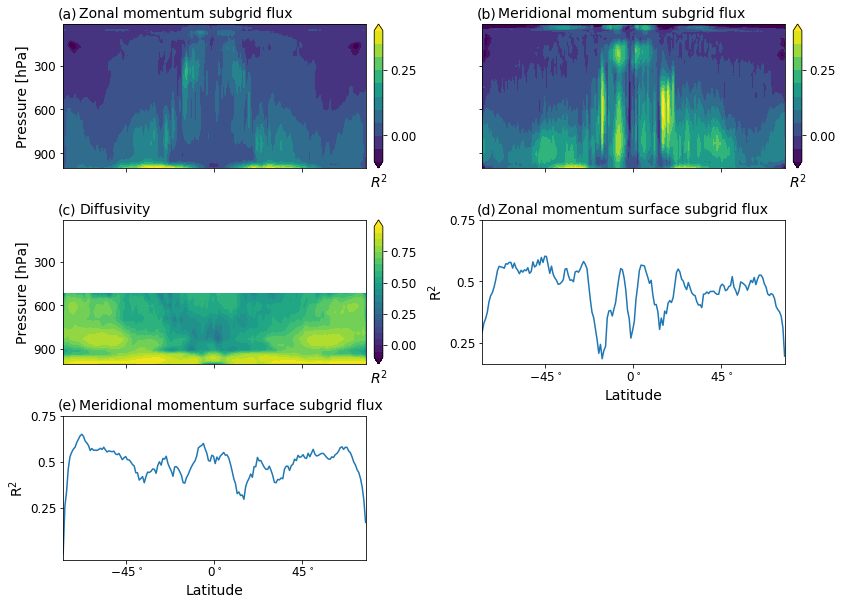

In [25]:
# plot_R2_contourf_production(r2_full,y,indices,p,save = 1, save_name = "r2_true_production")

coarse_factor = 2
y_coarse = np.zeros(int(y.shape[0]/coarse_factor))
for i in range(y_coarse.shape[0]):
    y_coarse[i] = np.mean(y[int(coarse_factor*i):int(coarse_factor*(i+1))])
    
    
# plot_R2_contourf_production(r2_coarse,y_coarse,indices,p,save = 1, save_name = "r2_coarse_production",coarse_flag=True)
# plot_R2_contourf_production(r2_full,y,indices,p,save = 0, save_name = "r2_true_production",coarse_flag=False)
# plot_R2_contourf_production(r2_coarse,y_coarse,indices,p,save = 1, save_name = "r2_coarse_fact_2_production_x4_scale",coarse_flag=False)
# plot_R2_contourf_production(r2_coarse,y_coarse,indices,p,save = 1, save_name = "r2_coarse_fact_2_production_x4_scale_many_colors",coarse_flag=False)
# plot_R2_contourf_production(r2_full,y,indices,p,save = True, 
#                             save_name = "r2_true_production_many_colors_no_c_grid_5_layers",
#                             coarse_flag=False,lev_Rsq = np.arange(-0.1, 0.67, 0.1),
#                             Rsq_ticks1=np.arange(-0.1, 0.7, 0.2))

plot_R2_contourf_production(r2_full,y,indices,p,save = True, 
                            save_name = "r2_true_production_many_colors_with_c_grid_5_layers_same_scale",
                            coarse_flag=False,lev_Rsq = np.arange(-0.1, 0.45, 0.05),
                            Rsq_ticks1=[0,0.25,0.5,0.75])



## Compare to Seager parameterization. 

In [17]:
def calc_precip(q, rho, z):
# surface precipitation rate given tendency of specific humidity
    precip = -vertical_integral(q, rho, z)
    return precip

def vertical_integral(data, rho, z):
# vertical integral with respect to sigma
    rho_dz = vertical_diff(rho, z)
    int_data = np.sum(data * rho_dz[:,None], axis=0)
    return int_data

def vertical_diff(rho, z):
    # follow vertical differencing from setgrid.f90 in SAM
    # changed indexing from starting at 1 to 0
    nzm = z.size
    adz = np.zeros(nzm)    
    dz = 0.5*(z[0]+z[1]) 
    adz[0] = 1.
    for k in range(1,nzm-1): # range doesn't include stopping number
        adz[k] = 0.5*(z[k+1]-z[k-1])/dz

    adz[nzm-1] = (z[nzm-1]-z[nzm-2])/dz

    rho_dz = adz*dz*rho

    return rho_dz

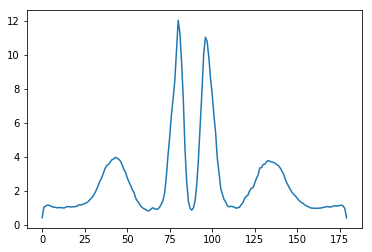

In [18]:
precip = np.zeros((v_48_lev['qout'].shape[1],v_48_lev['qout'].shape[2],v_48_lev['qout'].shape[3]))
for xi in range(v_48_lev['qout'].shape[2]):
    for ti in range(v_48_lev['qout'].shape[3]):
        precip[:,xi,ti] = calc_precip(v_48_lev['qout'][:,:,xi,ti], rho[0:48], z[0:48])*24*3600
plt.plot(np.mean(precip,axis=(1,2)))

#### Calculate tendency from the fluxes:

In [19]:
adzdz = vertical_diff(rho, z)

In [40]:
with_surface_fluxes = 0


u_tend = np.zeros((v_mom['u_flux'].shape[0] + 1,v_mom['u_flux'].shape[1],v_mom['u_flux'].shape[2],v_mom['u_flux'].shape[3]))
u_flux_ext = np.zeros((v_mom['u_flux'].shape[0] + 2,v_mom['u_flux'].shape[1],v_mom['u_flux'].shape[2],v_mom['u_flux'].shape[3]))
u_flux_ext[1:48,:,:,:] = v_mom['u_flux']
if with_surface_fluxes:
    u_flux_ext[0,:,:,:] = v_mom['u_surf']*dz
for yi in range(v_mom['u_flux'].shape[1]):
    for xi in range(v_mom['u_flux'].shape[2]):
        for ti in range(v_mom['u_flux'].shape[3]):
            u_tend[:,yi,xi,ti] = (-u_flux_ext[1:,yi,xi,ti]  + u_flux_ext[0:-1,yi,xi,ti])/adzdz

In [49]:
v_tend = np.zeros((v_mom['u_flux'].shape[0] + 1,v_mom['u_flux'].shape[1],v_mom['u_flux'].shape[2],v_mom['u_flux'].shape[3]))
v_flux_ext = np.zeros((v_mom['u_flux'].shape[0] + 2,v_mom['u_flux'].shape[1],v_mom['u_flux'].shape[2],v_mom['u_flux'].shape[3]))
v_flux_ext[1:48,:,:,:] = v_mom['v_flux']
if with_surface_fluxes:
    v_flux_ext[0,:,:,:] = v_mom['v_surf']*dz
for yi in range(v_mom['v_flux'].shape[1]):
    for xi in range(v_mom['v_flux'].shape[2]):
        for ti in range(v_mom['v_flux'].shape[3]):
            v_tend[:,yi,xi,ti] = (-v_flux_ext[1:,yi,xi,ti]  + v_flux_ext[0:-1,yi,xi,ti])/adzdz

In [50]:
inv_output_pred_test_3D_res = np.moveaxis(inv_output_pred_test_3D[15:15+47,:,:,:],1,3)
u_tend_pred = np.zeros((v_mom['u_flux'].shape[0] + 1,v_mom['u_flux'].shape[1],v_mom['u_flux'].shape[2],v_mom['u_flux'].shape[3]))
u_flux_ext = np.zeros((v_mom['u_flux'].shape[0] + 2,v_mom['u_flux'].shape[1],v_mom['u_flux'].shape[2],v_mom['u_flux'].shape[3]))
u_flux_ext[1:48,:,:,:] = inv_output_pred_test_3D_res
for yi in range(v_mom['u_flux'].shape[1]):
    for xi in range(v_mom['u_flux'].shape[2]):
        for ti in range(v_mom['u_flux'].shape[3]):
            u_tend_pred[:,yi,xi,ti] = (-u_flux_ext[1:,yi,xi,ti]  + u_flux_ext[0:-1,yi,xi,ti])/adzdz

In [51]:
inv_output_pred_test_3D_res = np.moveaxis(inv_output_pred_test_3D[15+47:15+94,:,:,:],1,3)
v_tend_pred = np.zeros((v_mom['u_flux'].shape[0] + 1,v_mom['u_flux'].shape[1],v_mom['u_flux'].shape[2],v_mom['u_flux'].shape[3]))
v_flux_ext = np.zeros((v_mom['u_flux'].shape[0] + 2,v_mom['u_flux'].shape[1],v_mom['u_flux'].shape[2],v_mom['u_flux'].shape[3]))
v_flux_ext[1:48,:,:,:] = inv_output_pred_test_3D_res
for yi in range(v_mom['u_flux'].shape[1]):
    for xi in range(v_mom['u_flux'].shape[2]):
        for ti in range(v_mom['u_flux'].shape[3]):
            v_tend_pred[:,yi,xi,ti] = (-v_flux_ext[1:,yi,xi,ti]  + v_flux_ext[0:-1,yi,xi,ti])/adzdz

In [52]:
latitudes_trop = np.arange(70,110,1)
zlevel= 25 # 213hPa
# zlevel= 24 # 232hPa
# zlevel= 20 # 232hPa
# zlevel= 15 # 232hPa
u_diff_200 = v_mom['uin'][4,:,:,:] - v_mom['uin'][zlevel,:,:,:]
u_diff_200_vec = v_mom['uin'][4,:,:,:] - v_mom['uin'][:,:,:,:]

In [53]:

precip_mean_trop = np.mean(precip[latitudes_trop,:,:],axis=(1,2))
seager_param = precip_mean_trop * np.mean(u_diff_200[latitudes_trop,:,:],axis = (1,2))
seager_param_vec = precip_mean_trop[None,:] * np.mean(u_diff_200_vec[:,latitudes_trop,:,:],axis = (2,3))





In [54]:
true_out_xt_avg = np.mean(u_tend[zlevel,latitudes_trop,:,:],axis = (1,2))
true_out_xt_avg_vec = np.mean(u_tend[:,latitudes_trop,:,:],axis = (2,3))
pred_out_xt_avg = np.mean(u_tend_pred[zlevel,latitudes_trop,:,:],axis = (1,2))
pred_out_xt_avg_vec = np.mean(u_tend_pred[:,latitudes_trop,:,:],axis = (2,3))

In [55]:
# Calculate the correlation at every level
corr_NN_vec = np.zeros(true_out_xt_avg_vec.shape[0])
corr_seager_vec = np.zeros(true_out_xt_avg_vec.shape[0])
for zi in range(true_out_xt_avg_vec.shape[0]):
    corr_NN_vec[zi], _ = pearsonr(true_out_xt_avg_vec[zi,precip_mean_trop>2],pred_out_xt_avg_vec[zi,precip_mean_trop>2])
    corr_seager_vec[zi], _ = pearsonr(true_out_xt_avg_vec[zi, precip_mean_trop>2],seager_param_vec[zi,precip_mean_trop>2])
    
    

/glade/work/janniy/python_ncar_env/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


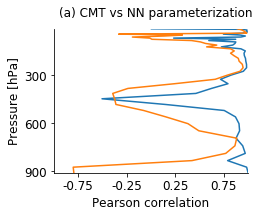

In [92]:
fontsize = 12
fontsize_legend = 8
ticks_lat = [-5,0,5]

# ticks_pmean = [0,0.2,0.4,0.6,0.8]
# ticks_px = ticks_pmean #np.arange(0,900,100)

# ticks_px_offline = ticks_pmean
# ticks_pmean_offline = ticks_pmean


# linewidth=1.5

true_range1 = -0.000005
true_range2 = 0.00001

true_ticks = [-0.000004,0,0.000004,0.000008]

h_width = 0.1
v_width = 0.1
h_width_cbar = 0.02
colorbar_width =0.02

row_dim = 2
col_dim = 2

fig_witdth = 0.45
fig_height = 0.5
fig_h_dist = 0.08
fig_v_dist = 0.15
mm_rain = 0


letters = ["(a) CMT vs NN parameterization","(b)  NN parameterization","(b) NN parameterization" ,"(d)"]
# letters = [r"(a) CMT vs. Prec(u(0.6km) - u)","(b)  NN parameterization","(b) NN parameterization" ,"(d)"]

# CMT’b3P3(u925 2u)
# headers = ["$q_t$ tend" +str(r2[0]),"26 lev (48 inputs) $R^2=$"+str(r2[1]),"38 lev $R^2=$"+str(r2[2]),"48 lev $R^2=$"+str(r2[3])]

colors1 = ['red','black','blue','green']
fig, axes = plt.subplots(row_dim,col_dim)

# cax_q_mean_offline = axes[0,0].plot(y_plot,  precip_mean_true * per_day, label='True', linewidth=linewidth,color=colors1[0])#,linestyle=':')
# cax_q_mean_offline2 = axes[0,0].plot(y_plot,  precip_mean_pred * per_day, label='Pred',linestyle='-.', linewidth=linewidth,color=colors1[1])
cax_mean_online2 =axes[0,0].plot(corr_NN_vec[5:],p[5:])
cax_mean_online2 =axes[0,0].plot(corr_seager_vec[5:],p[5:])
axes[0,0].set_xlim(-1, 1)
axes[0,0].set_ylim(p[5], p[-1])

fig.delaxes(axes[0,1])
fig.delaxes(axes[1,0])
fig.delaxes(axes[1,1])
#Position of first figure        
x0 = axes[0,0].get_position().x0
x1 = axes[0,0].get_position().x1
y0 = axes[0,0].get_position().y0
y1 = axes[0,0].get_position().y1

for i in range(row_dim):
    for j  in range(col_dim):
        axes[i,j].set_position([x0 + j*fig_witdth + j*fig_h_dist,y0- i*fig_height - i*fig_v_dist,fig_witdth,fig_height])
        
    
ind_let = 0
for i in range(row_dim):
    for j  in range(col_dim):
        atext2 = axes[i, j].text(axes[0,0].get_position().x0*1.1+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.8- (i-1)*fig_height - (i-1)*fig_v_dist ,letters[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)
        
#         header= axes[i, j].text(axes[0,0].get_position().x0*1.5+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.92- (i-1)*fig_height - (i-1)*fig_v_dist ,headers[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)
        ind_let = ind_let + 1
true_ticks = [-0.75, -0.25, 0.25, 0.75]
press_lev = [300,600,900]


axes[0, 0].set_xticks(true_ticks)
axes[0, 0].set_xticklabels(true_ticks,fontsize=fontsize)
axes[0, 0].set_yticks(press_lev)
axes[0, 0].set_yticklabels(press_lev,fontsize=fontsize)



axes[0,0].spines["top"].set_visible(False)
axes[0,0].spines["right"].set_visible(False)

axes[0, 0].set_ylabel('Pressure [hPa]',fontsize=fontsize)
axes[0, 0].set_xlabel('Pearson correlation',fontsize=fontsize)

# #Saving plot... fxax
save_path = '/glade/work/janniy/data_for_offline_momentum_paper/plots/'


# plt.savefig(save_path+'momentum_parameterization_seager_vs_NN_all_level_pearson.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_seager_vs_NN_all_level_pearson_no_c_grid.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_seager_vs_NN_all_level_pearson_no_c_grid_5_layers.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_seager_vs_NN_all_level_pearson_no_c_grid_5_layers_501_snapshots.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_seager_vs_NN_all_level_pearson_with_c_grid_5_layers_501_snapshots.eps', format='eps', bbox_inches="tight")




/glade/work/janniy/python_ncar_env/lib/python3.6/site-packages/ipykernel_launcher.py:36: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


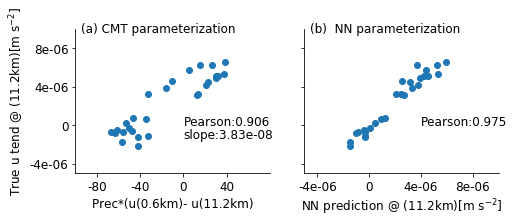

In [56]:
fontsize = 12
fontsize_legend = 8
ticks_lat = [-5,0,5]

# ticks_pmean = [0,0.2,0.4,0.6,0.8]
# ticks_px = ticks_pmean #np.arange(0,900,100)

# ticks_px_offline = ticks_pmean
# ticks_pmean_offline = ticks_pmean


# linewidth=1.5

true_range1 = -0.000005
true_range2 = 0.00001

true_ticks = [-0.000004,0,0.000004,0.000008]

h_width = 0.1
v_width = 0.1
h_width_cbar = 0.02
colorbar_width =0.02

row_dim = 2
col_dim = 2

fig_witdth = 0.45
fig_height = 0.5
fig_h_dist = 0.08
fig_v_dist = 0.15
mm_rain = 0
corr_paramet, _ = pearsonr(seager_param[precip_mean_trop>2],true_out_xt_avg[precip_mean_trop>2])
corr_paramet_RF, _ = pearsonr(true_out_xt_avg[precip_mean_trop>2],pred_out_xt_avg[precip_mean_trop>2])
slope, intercept, r_value, p_value, std_err = stats.linregress(seager_param[precip_mean_trop>2],true_out_xt_avg[precip_mean_trop>2])

slope_no_intercept, _, _, _ = np.linalg.lstsq(seager_param[precip_mean_trop>2,None],true_out_xt_avg[precip_mean_trop>2]) 
# = stats.linregress(seager_param[precip_mean_trop>2],true_out_xt_avg[precip_mean_trop>2])


marker1 = 100
markers_style = ['x','^','o']
letters = ["(a) CMT parameterization","(b)  NN parameterization","(b) NN parameterization" ,"(d)"]
# letters = [r"(a) CMT vs. Prec(u(0.6km) - u)","(b)  NN parameterization","(b) NN parameterization" ,"(d)"]

# CMT’b3P3(u925 2u)
# headers = ["$q_t$ tend" +str(r2[0]),"26 lev (48 inputs) $R^2=$"+str(r2[1]),"38 lev $R^2=$"+str(r2[2]),"48 lev $R^2=$"+str(r2[3])]

colors1 = ['red','black','blue','green']
fig, axes = plt.subplots(row_dim,col_dim)

# cax_q_mean_offline = axes[0,0].plot(y_plot,  precip_mean_true * per_day, label='True', linewidth=linewidth,color=colors1[0])#,linestyle=':')
# cax_q_mean_offline2 = axes[0,0].plot(y_plot,  precip_mean_pred * per_day, label='Pred',linestyle='-.', linewidth=linewidth,color=colors1[1])
cax_mean_online2 =axes[0,0].scatter(seager_param[precip_mean_trop>2],true_out_xt_avg[precip_mean_trop>2])



axes[0,0].set_xlim(-100, 80)
axes[0,0].set_ylim(true_range1, true_range2)


cax_mean_online3 = axes[0,1].scatter(pred_out_xt_avg[precip_mean_trop>2],true_out_xt_avg[precip_mean_trop>2])


axes[0,1].set_xlim(true_range1, true_range2)
axes[0,1].set_ylim(true_range1, true_range2)

fig.delaxes(axes[1,0])
fig.delaxes(axes[1,1])
#Position of first figure        
x0 = axes[0,0].get_position().x0
x1 = axes[0,0].get_position().x1
y0 = axes[0,0].get_position().y0
y1 = axes[0,0].get_position().y1

for i in range(row_dim):
    for j  in range(col_dim):
        axes[i,j].set_position([x0 + j*fig_witdth + j*fig_h_dist,y0- i*fig_height - i*fig_v_dist,fig_witdth,fig_height])
        
    
ind_let = 0
for i in range(row_dim):
    for j  in range(col_dim):
        atext2 = axes[i, j].text(axes[0,0].get_position().x0*1.1+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.7- (i-1)*fig_height - (i-1)*fig_v_dist ,letters[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)
        
#         header= axes[i, j].text(axes[0,0].get_position().x0*1.5+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.92- (i-1)*fig_height - (i-1)*fig_v_dist ,headers[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)
        ind_let = ind_let + 1


# ticks_lat_degrees = ['$-45^\circ$','$0^\circ$','$45^\circ$']
# axes[1, 0].set_xticks(ticks_lat)
# axes[1, 0].set_xticklabels(ticks_lat_degrees,fontsize=fontsize)
# axes[1, 0].set_yticks(ticks_px_offline)
# axes[1, 0].set_yticklabels(ticks_px_offline,fontsize=fontsize)

axes[0, 1].set_xticks(true_ticks)
axes[0, 1].set_xticklabels(true_ticks,fontsize=fontsize)
axes[0, 1].set_yticks(true_ticks)
axes[0, 1].set_yticklabels([])

axes[0, 0].set_yticks(true_ticks)
axes[0, 0].set_yticklabels(true_ticks,fontsize=fontsize)
axes[0, 0].set_xticks([-80,-40,0,40])
axes[0, 0].set_xticklabels([-80,-40,0,40],fontsize=fontsize)


# axes[0, 0].set_yticks(ticks_pmean_offline)
# axes[0, 0].set_yticklabels(ticks_pmean_offline,fontsize=fontsize)
# axes[0, 0].set_xticks(ticks_lat)
# axes[0, 0].set_xticklabels([])


# axes[1, 1].set_xticks(ticks_lat)
# axes[1, 1].set_xticklabels(ticks_lat_degrees,fontsize=fontsize)
# axes[1, 1].set_yticks(ticks_px)
# axes[1, 1].set_yticklabels(ticks_px)



axes[0, 1].set_xlabel('NN prediction @ (' + "{:.1f}".format(z[zlevel]/1000) + 'km)' + '[m s$^{-2}$]',fontsize=fontsize)
# axes[1, 0].set_xlabel('RF prediction @ (9km)',fontsize=fontsize)

# axes[1, 0].set_ylabel('True u tend @ (11.2km) [m s$^{-2}$]',fontsize=fontsize)
# axes[1, 0].set_ylabel('True u tend @ (9km) [m s$^{-2}$]',fontsize=fontsize)

# axes[0, 0].set_xlabel(r'Prec*(u(0.6km) - u(11.2km)) [mm m s$^{-1}$ day$^{-1}]',fontsize=fontsize)
# axes[0, 0].set_xlabel(r'Prec*(u(0.6km) - u(11.2km))' ,fontsize=fontsize)
axes[0, 0].set_xlabel(r'Prec*(u(0.6km)- u(' + "{:.1f}".format(z[zlevel]/1000) + 'km)' ,fontsize=fontsize)
# 'NN prediction @ ('+  "{:.1f}".format(z[zlevel]/1000) + 'km) [m s$^{-2}$]'

# axes[0, 0].set_xlabel('Const * Prec*(u(0.6km) - u(9km))',fontsize=fontsize)
axes[0, 0].set_ylabel(r'True u tend @ (' + "{:.1f}".format(z[zlevel]/1000) + 'km)' + r'[m s$^{-2}$]',fontsize=fontsize)
# axes[0, 0].set_ylabel('True u tend @ (9km) [m s$^{-2}$]',fontsize=fontsize)



axes[0, 0].text(0, 0, 'Pearson:' + str(round(corr_paramet,3)),fontsize=fontsize)
# axes[0, 0].text(0, 0-0.0000014, 'slope:' + "{:.2e}".format(slope),fontsize=fontsize)
axes[0, 0].text(0, 0-0.0000014, 'slope:' + "{:.2e}".format(slope_no_intercept[0]),fontsize=fontsize)

axes[0, 1].text(4e-6, 0, 'Pearson:' + str(round(corr_paramet_RF,3)),fontsize=fontsize)

# scientific_notation = "{:.2e}".format(slope)
# scientific_notation

#  + 'pearson:' + str(round(corr_paramet,3))
# + 'pearson:' + str(round(corr_paramet_RF,3))


axes[0,0].spines["top"].set_visible(False)
axes[0,0].spines["right"].set_visible(False)


axes[0,1].spines["top"].set_visible(False)
axes[0,1].spines["right"].set_visible(False)

axes[1,1].spines["top"].set_visible(False)
axes[1,1].spines["right"].set_visible(False)

axes[1,0].spines["top"].set_visible(False)
axes[1,0].spines["right"].set_visible(False)




# #Saving plot... fxax
save_path = '/glade/work/janniy/data_for_offline_momentum_paper/plots/'


# plt.savefig(save_path+'momentum_parameterization_scatter.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_112km.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_107km_production.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_8_5km_production.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_5_7km_production.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_112km_no_c_grid.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_112km_no_c_grid_5_layers.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_112km_no_c_grid_5_layers_501_snapshpts.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_112km_with_c_grid_5_layers_501_snapshpts.eps', format='eps', bbox_inches="tight")



In [57]:
Umean1 = np.mean(loaded['uin'],axis=(2,3))
dU1 = Umean1[:-1,:] - Umean1[1:,:]
dz1 = z[:-1] - z[1:]
dU_dz = dU1/dz1[:,None] 

(47, 180)
(47,)
(180,)


/glade/work/janniy/python_ncar_env/lib/python3.6/site-packages/ipykernel_launcher.py:245: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


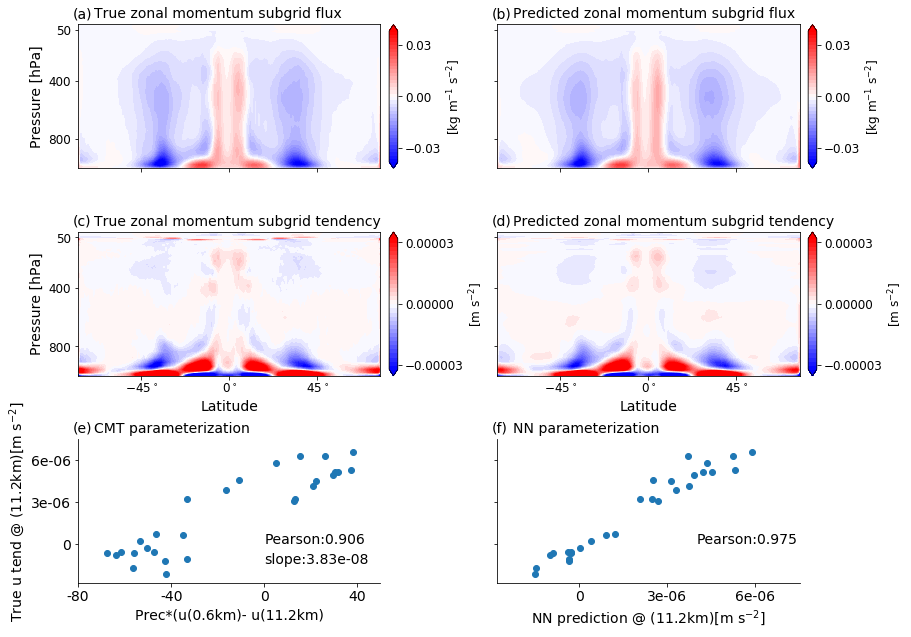

In [75]:
# trop_ind,trop_z,trop_p = calc_lapse_rate(v_48_lev['Tin'],z,min_lev_trop_ind=10)
plot_mean_4_2Dfields_2_1D_production(np.mean(np.moveaxis(inv_output_true_test_3D[15:15+47,:,:,:],0,2),axis = (0,3)),
                              np.mean(np.moveaxis(u_tend,0,2),axis = (1,3)),
                              np.mean(np.moveaxis(inv_output_pred_test_3D[15:15+47,:,:,:],0,2),axis = (0,3)),
                              np.mean(np.moveaxis(u_tend_pred,0,2),axis = (1,3)),
                              y,indices,p, precip_mean_trop,
                              seager_param, true_out_xt_avg, pred_out_xt_avg, pearson_lev = z[zlevel],
#                               save = True, save_name = "u_flux_TEND_true_and_pred_x8_no_c_grid_with_seager_501snapshots_with_shear",with_trop=False,trop_p = trop_p,
                              save = True, save_name = "u_flux_TEND_true_and_pred_x8_with_c_grid_with_seager_501snapshots_no_shear_sponge_tick",with_trop=False,trop_p = [],
                              plot_shear=False, shear = dU_dz, colorbar_costum_scale = True, 
                              color1 = np.arange(-0.038,0.039,0.002),
                              color1_ticks = [-0.03,0,0.03],
                              color3 = np.arange(-0.000032,0.000033,0.000002),
                              color3_ticks = [-0.00003,0,0.00003],
#                               color3 = np.arange(-0.000120,0.000131,0.00001),
#                               color3_ticks = [-0.00008,0,0.00008],
                              color2 = np.arange(-0.038,0.039,0.002),
                              color2_ticks = [-0.03,0,0.03],
                              color4 = np.arange(-0.000032,0.000033,0.000002),
                              color4_ticks = [-0.00003,0,0.00003],
#                               color4 = np.arange(-0.000120,0.000131,0.00001),
#                               color4_ticks = [-0.00008,0,0.00008],
                                     label1='[kg m$^{-1}$ s$^{-2}$]',label3='[m s$^{-2}$]',
                                     label2='[kg m$^{-1}$ s$^{-2}$]',label4='[m s$^{-2}$]',
                             headers = [r"True zonal momentum subgrid flux",r"Predicted zonal momentum subgrid flux",r"True zonal momentum subgrid tendency",r"Predicted zonal momentum subgrid tendency",r"CMT parameterization",r"NN parameterization"])
    


# Plot mean flux and tendencies

(47, 180)
(47,)
(180,)


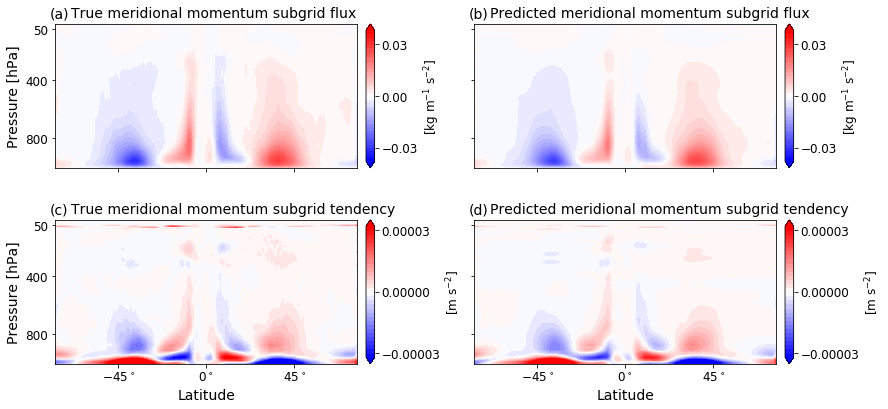

In [78]:
trop_ind,trop_z,trop_p = calc_lapse_rate(v_48_lev['Tin'],z,p,min_lev_trop_ind=10)
plot_mean_4_fields_production(np.mean(np.moveaxis(inv_output_true_test_3D[15+47:15+47+47,:,:,:],0,2),axis = (0,3)),
                              np.mean(np.moveaxis(v_tend,0,2),axis = (1,3)),
                              np.mean(np.moveaxis(inv_output_pred_test_3D[15+47:15+47+47,:,:,:],0,2),axis = (0,3)),
                              np.mean(np.moveaxis(v_tend_pred,0,2),axis = (1,3)),
                              y,indices,p,save = True, save_name = "v_flux_TEND_true_and_pred_x8_no_c_grid_501_snapshots_tick_at_sponge",with_trop=False,trop_p = trop_p,
                              plot_shear=False, shear = [], colorbar_costum_scale = True, 
                              color1 = np.arange(-0.038,0.039,0.002),
                              color1_ticks = [-0.03,0,0.03],
                              color3 = np.arange(-0.000032,0.000033,0.000002),
                              color3_ticks = [-0.00003,0,0.00003],
                              color2 = np.arange(-0.038,0.039,0.002),
                              color2_ticks = [-0.03,0,0.03],
                              color4 = np.arange(-0.000032,0.000033,0.000002),
                              color4_ticks = [-0.00003,0,0.00003],
                             headers = [r"True meridional momentum subgrid flux",r"Predicted meridional momentum subgrid flux",r"True meridional momentum subgrid tendency",r"Predicted meridional momentum subgrid tendency",r"Moisture surface subgrid flux",r"diffusivity RF"])

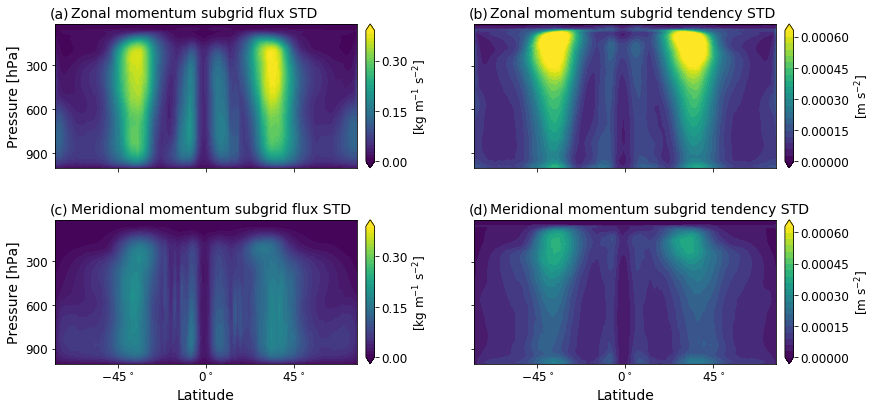

In [131]:
plot_std_4_fields_production(np.std(np.moveaxis(inv_output_true_test_3D[15:15+47,:,:,:],0,2),axis = (0,3)),
                              np.std(np.moveaxis(inv_output_true_test_3D[15+47:15+47*2,:,:,:],0,2),axis = (0,3)),
                              np.std(np.moveaxis(u_tend,0,2),axis = (1,3)),
                              np.std(np.moveaxis(v_tend,0,2),axis = (1,3)),
                              y,indices,p,save = False, save_name = "u_v_flux_tend_trop_STD_x8_true_with_c_grid_501_snapshots",with_trop=False,trop_p = [],
                            lev_Rsq = np.arange(0,0.4,0.01),
                            lev_Rsq_ticks = np.arange(0,0.4,0.15),
                            lev_Rsq2 = np.arange(0,0.00065,0.00003),
                            lev_Rsq_ticks2 = np.arange(0,0.00065,0.00015))


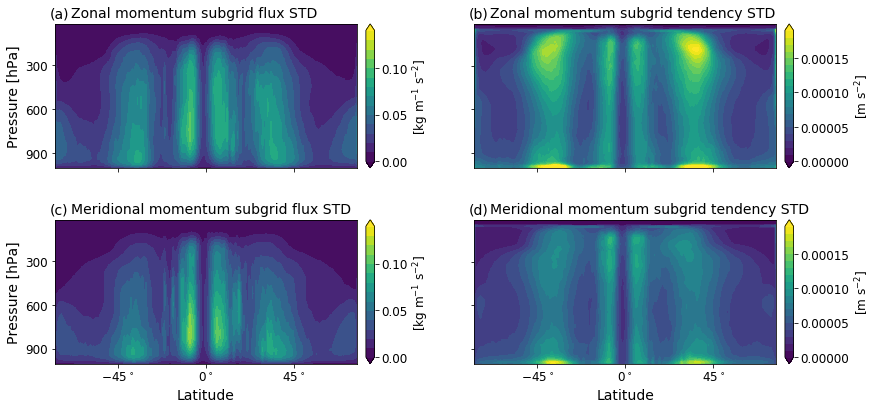

In [98]:
plot_std_4_fields_production(np.std(np.moveaxis(inv_output_true_test_3D[15:15+47,:,:,:],0,2),axis = (0,3)),
                              np.std(np.moveaxis(inv_output_true_test_3D[15+47:15+47*2,:,:,:],0,2),axis = (0,3)),
                              np.std(np.moveaxis(u_tend,0,2),axis = (1,3)),
                              np.std(np.moveaxis(v_tend,0,2),axis = (1,3)),
                              y,indices,p,save = True, save_name = "u_v_flux_tend_trop_STD_x8_true_no_c_grid_501_snapshots",with_trop=False,trop_p = [],
                            lev_Rsq = np.arange(0,0.14,0.01),
                            lev_Rsq_ticks = np.arange(0,0.16,0.05),
                            lev_Rsq2 = np.arange(0,0.0002,0.00001),
                            lev_Rsq_ticks2 = np.arange(0,0.0002,0.00005))


## Plot time dependent

In [81]:
true_u_flux = inv_output_true_test_3D[15:15+47,:,:,:]
pred_u_flux = inv_output_pred_test_3D[15:15+47,:,:,:]

In [82]:
true_v_flux = inv_output_true_test_3D[15+47:15+47*2,:,:,:]
pred_v_flux = inv_output_pred_test_3D[15+47:15+47*2,:,:,:]

In [83]:
def vertical_integral3D(data, rho, z):
# vertical integral with respect to sigma
    rho_dz = vertical_diff(rho, z)
    int_data = np.sum(data * rho_dz[:,None,None,None], axis=0)
    return int_data

In [84]:
ones = np.zeros(rho.shape)
ones = ones + 1
true_u_flux_int= vertical_integral3D(true_u_flux,ones[0:47],z[0:47])
pred_u_flux_int= vertical_integral3D(pred_u_flux,ones[0:47],z[0:47])

true_v_flux_int= vertical_integral3D(true_v_flux,ones[0:47],z[0:47])
pred_v_flux_int= vertical_integral3D(pred_v_flux,ones[0:47],z[0:47])

In [85]:
true_v_flux_vert_mean = np.mean(true_v_flux,axis=0)
pred_v_flux_vert_mean = np.mean(pred_v_flux,axis=0)

true_u_flux_vert_mean = np.mean(true_u_flux,axis=0)
pred_u_flux_vert_mean = np.mean(pred_u_flux,axis=0)

(100,)
(47,)
(47, 100)


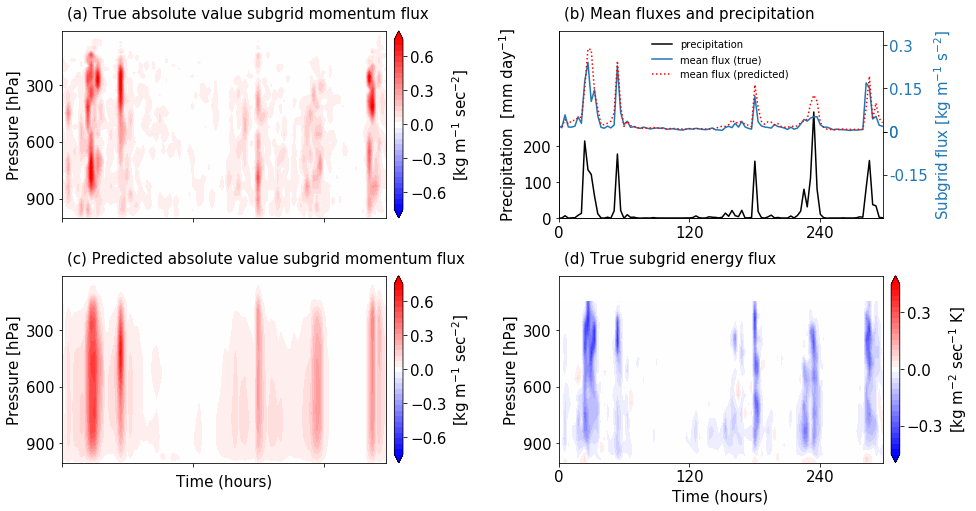

In [80]:
plot_sapshots_2x2_mom_energy_switch(true_u_flux,np.moveaxis(v_48_lev['Tadv'],3,1), pred_u_flux,true_u_flux_vert_mean,pred_u_flux_vert_mean,precip,p,y_i=96,
                                    save_flag=True,
                                    time_ind1=125,
                                    time_ind2=225,
                                    x_ind1=66,
              save_name1='momentum_precip_energy_vs_time_pressure_narrow_mean_vert_no_c_grid_all_new_ABS',plot_trop=False,trop_p = [],flux_ticks_colorbarT = np.arange(-0.6,0.65,0.3),
                                   sat_fact = 1.0,range_momentum = 0.75,range_energy=0.45, precip_labels = [0,100, 200],
                                   flux_ticks_label=[0, -0.15, 0, 0.15,0.3],
                                   y_lim1 =-0.3000, y_lim2 =0.3500,
                                   letters = ["(a) True absolute value subgrid momentum flux","(b) Mean fluxes and precipitation",'(c) Predicted absolute value subgrid momentum flux','(d) True subgrid energy flux','','','','']
                                   )
#26,7,46,56

(100,)
(47,)
(47, 100)


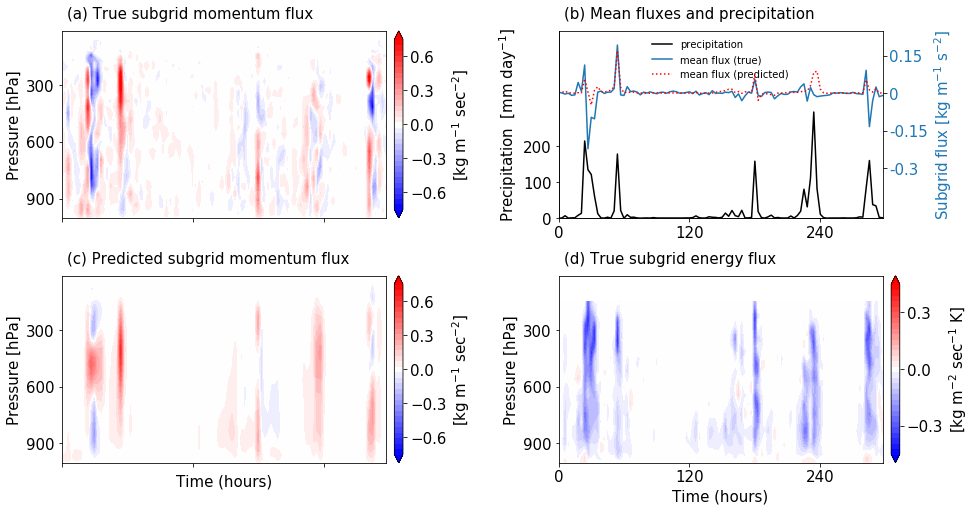

In [102]:
plot_sapshots_2x2_mom_energy_switch(true_u_flux,np.moveaxis(v_48_lev['Tadv'],3,1), pred_u_flux,true_u_flux_vert_mean,pred_u_flux_vert_mean,precip,p,y_i=96,
                                    save_flag=True,
                                    time_ind1=125,
                                    time_ind2=225,
                                    x_ind1=66,
              save_name1='momentum_precip_energy_vs_time_pressure_narrow_mean_vert_no_c_grid_all_new',plot_trop=False,trop_p = [],flux_ticks_colorbarT = np.arange(-0.6,0.65,0.3),
                                   sat_fact = 1.0,range_momentum = 0.75,range_energy=0.45, precip_labels = [0,100, 200],
                                   flux_ticks_label=[-0.3, -0.15, 0, 0.15],
                                   y_lim1 =-0.5000, y_lim2 =0.2500,)
#26,7,46,56

(100,)
(47,)
(47, 100)


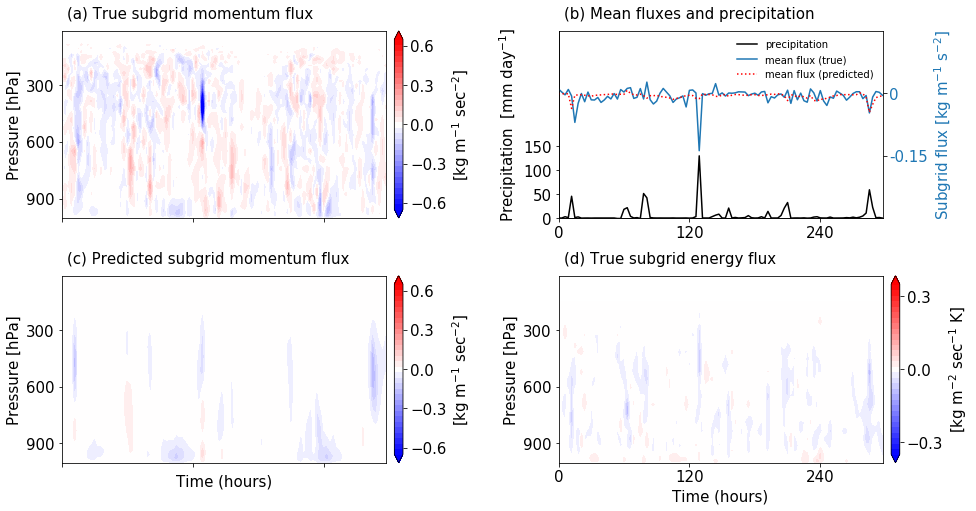

In [91]:
plot_sapshots_2x2_mom_energy_switch(true_u_flux,np.moveaxis(v_48_lev['Tadv'],3,1), 
                             pred_u_flux,true_u_flux_vert_mean,pred_u_flux_vert_mean,precip,p,
                             y_i=130,save_flag=False,
              save_name1='momentum_precip_energy_vs_time_pressure_narrow_mean_vert_no_c_grid_all_extra_5_layer_switch',
                             plot_trop=False,trop_p = [],flux_ticks_colorbarT = np.arange(-0.6,0.65,0.3),
                           flux_ticks_label = [-0.15, 0],
                            y_lim1 = -0.3, y_lim2 = 0.15, 
                            range_momentum = 0.65, range_energy =0.35,
                            time_ind1=125,
                            time_ind2=225,)
    
